# Portfolio Selection (for [QAIF@IFZ](https://www.hslu.ch/de-ch/hochschule-luzern/forschung/projekte/detail/?pid=5520))

We explore the quantum version of selecting list items by
a given condition, also known as (list) slicing by condition.
Here, the list items are numbers and we are interested in
taking list elements larger/smaller than a given number. By
means of binary search, the proposed method can be used as
a maximum/minimum function.

Consider that the efficient frontier of a portfolio universe is
calculated and presented to an investor, who would like to
choose portfolios among these optimal ones. More specifically,
it would be two lists of numbers, where one is the list
of returns and the other the list of corresponding standard
deviations of the optimal portfolios. In this case, our algorithm
can be used to do the filtering that maximizes
the investor’s preferences, e.g. "pick portfolios with return
larger than x% and standard deviation less than y". Another
case would be picking the portfolio with the best sharpe ratio,
which is achieved by employing the algorithm in a binary search.

### Import Libraries

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../GitHub/Plotter/')

import math

import numpy as np

from utils.gates import GreaterThanGate,LessThanGate
from utils.algorithms.grover import mQCS,GAS
from utils.algorithms.counting import get_count

from plotter import plotter

np.random.seed(1)

### Import Data

100%|██████████| 1/1 [00:00<00:00, 664.18it/s]


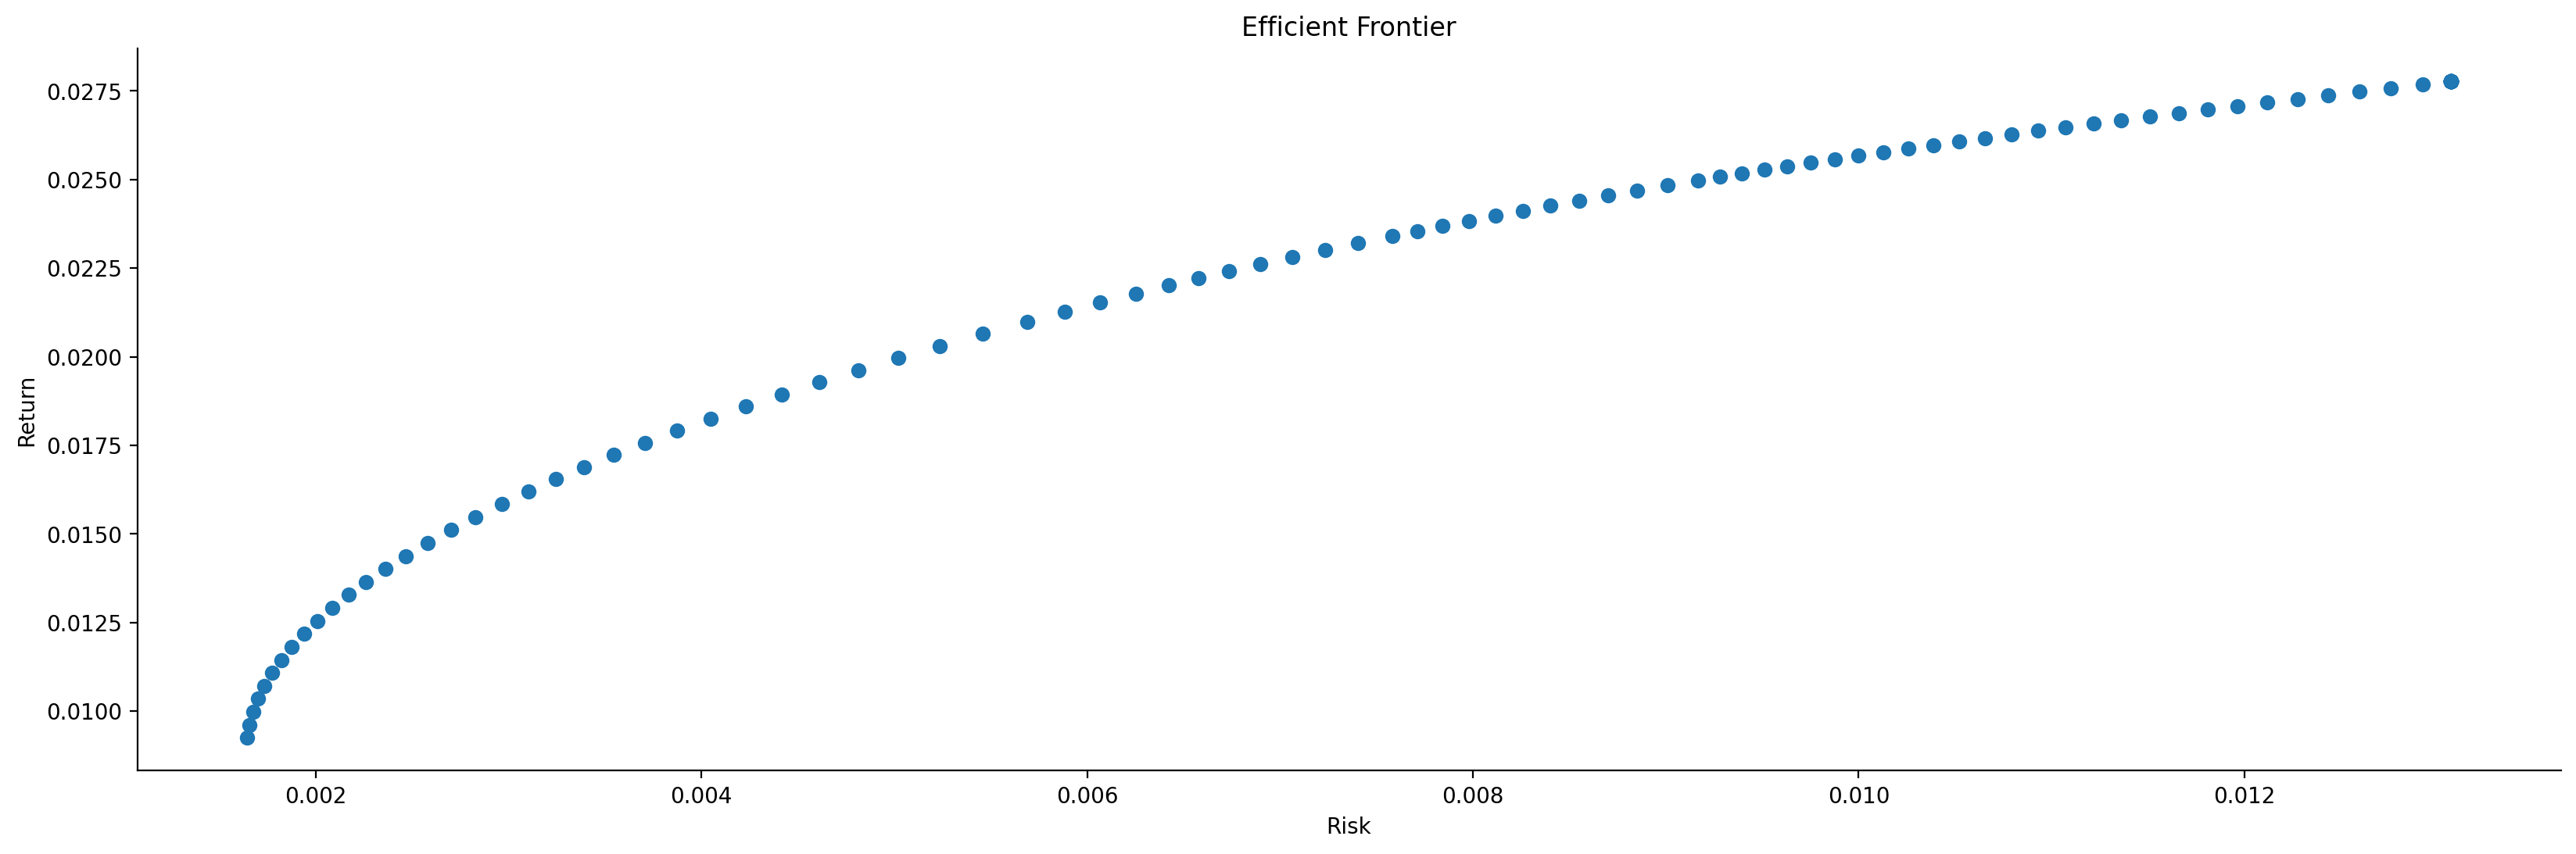

In [2]:
# 10 assets
optimal_risk_return_pairs = np.load('./return_risk_for_QAIF.npy')
returns, risks = optimal_risk_return_pairs.transpose()

plotter(
    [
        [
            [risks,returns],['Risk'],['Return'],['Efficient Frontier']
        ]
    ]
,['scatter'
,'set_xlabel','set_ylabel','set_title'],ncols=1)

#### Subsample data

In [3]:
returns, risks = optimal_risk_return_pairs.transpose()
subsample_complete = False
while not subsample_complete:
    subsample_indices = np.random.choice(len(returns),8)
    subsample_complete = np.unique(subsample_indices).size == subsample_indices.size
returns = returns[subsample_indices]
risks = risks[subsample_indices]

#### Resolving power and the number of qubits

In [4]:
risks *= 10

#### Risks and Returns

In [5]:
print(risks)
print(returns)

[0.06425008 0.02261188 0.11362174 0.02008393 0.1180976  0.01773916
 0.12434578 0.10256727]
[0.02201008 0.01364281 0.02667475 0.0125437  0.02697515 0.01107822
 0.02737567 0.0258737 ]


#### Sharpe ratios (assuming $r_0=0$)

In [6]:
sharpes = returns/risks
sharpes

array([0.34256887, 0.60334695, 0.23476804, 0.62456402, 0.22841401,
       0.6245064 , 0.22015762, 0.25226083])

### 1) Find portfolios with returns more than $r_{threshold}$ and standard deviation less than $\sigma_{threshold}$.

This is a Conditional Slicing problem two lists and conditions. We solve it with $\textbf{Quantum Exponential Search}$.

In [7]:
n_iqb = 3
d = 0.01
r_threshold = 0.02
sigma_threshold= 0.12
##############

N = 2**n_iqb
t = math.ceil(-math.log2(d)) # for greater-than / phase estimation

assert np.any(returns>r_threshold)
assert np.any(risks<sigma_threshold)
solutions = np.where((returns>r_threshold)*(risks<sigma_threshold))[0].tolist()
no_of_solutions = len(solutions)
print('(Classical) Solutions with indices:', solutions,'O(sqrt(N/M))=',np.sqrt(2**n_iqb/no_of_solutions))

f_check = lambda x: (returns[x]>r_threshold)*(risks[x]<sigma_threshold)

index_,_ = mQCS([returns,risks],[r_threshold,sigma_threshold],[GreaterThanGate(t),LessThanGate(t)],f_check=f_check)

print(f'(Quantum) Solution:{index_}')

(Classical) Solutions with indices: [0, 2, 4, 7] O(sqrt(N/M))= 1.4142135623730951
(Quantum) Solution:2


### 2) Find portfolios with the best Sharpe ratio.

We find the maximum value using $\textbf{Grover Adaptive Search}$.

In [8]:
GAS(sharpes,d)

3